In [13]:
# Load Google Drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive


In [14]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [15]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [16]:
# Import other libraries
!pip install keras_cv
import keras_cv
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers as tfkl
from tensorflow import keras as tfk
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [17]:
# Load data from Undersampled Dataset
data = np.load('/gdrive/My Drive/undersampled_dataset.npz', allow_pickle = True)
labels = data['labels']
images = data['data']

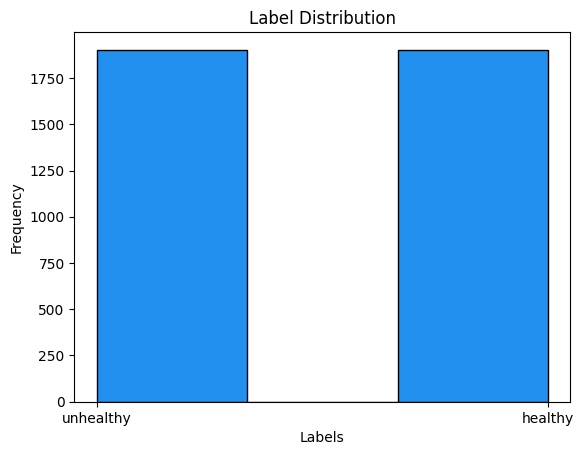

In [28]:
# Plot data distribution
plt.hist(labels, bins=3, color='#2290ee', edgecolor='black')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Label Distribution')
plt.show()

In [18]:
# Assign correct value to the labels
for k in range(len(labels)):
  if labels[k] == 'healthy':
    labels[k] = 0
  else:
    labels[k] = 1

# Transform labels into categorical variables
labels = tfk.utils.to_categorical(labels, num_classes=2)

In [19]:
# Split train/validation and test set
img_train_val, img_test, label_train_val, label_test = train_test_split(
    images, labels, random_state=seed, test_size=.10, stratify=labels
)

# Split train and validation set
img_train, img_val, label_train, label_val = train_test_split(
    img_train_val, label_train_val, random_state=seed, test_size=.20, stratify=label_train_val
)

In [20]:
# Define useful constants
input_shape = img_train.shape[1:]
output_shape = label_train.shape[1]
batch_size = 4
epochs = 100

In [21]:
# Early Stopping
callbacks = [
    tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, mode='auto'),
]

In [22]:
# Define the model: ConvNeXtBase
convolution = tfk.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    include_preprocessing=True, # Preprocess the input images
    weights="imagenet", # Network pre-trained on imagenet
    input_tensor=None,
    input_shape=input_shape,
    pooling="avg", # Global Average Pooling
    classes=2,
    classifier_activation="softmax", # Activation function is Softmax
)

# Set all the layers to Trainable
convolution.trainable=True

350926856/350926856 [==============================] - 6s 0us/step


In [23]:
# Augmentation
preprocessing = tfk.Sequential([
    tfkl.RandomTranslation(0.3, 0.3, seed=seed),
    tfkl.RandomFlip(seed=seed),
    tfkl.RandomRotation(0.25, seed=seed),
    keras_cv.layers.AutoContrast(value_range=(0, 255)),
    keras_cv.layers.RandomGaussianBlur(1, factor=(0.2, 0.5), seed=seed)
])

In [24]:
input_layer = tfkl.Input(shape=input_shape, name='Input') # Input Layer,  size = (96x96x3)

pre_layer = preprocessing(input_layer) # Augmentation Layer

mid_layer = convolution(pre_layer) # Convolution Layer

output_layer = tfkl.Dense(units=2, activation='softmax', name='Output')(mid_layer) # Output Layer, 2 neurons

# Define and compile the model
model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics=['accuracy'])

# In order to have everything normalized in the same way
img_train = tfk.Sequential(
    tfkl.BatchNormalization()
)(img_train)

In [25]:
# Fit the model
history = model.fit(
        x=img_train,
        y=label_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(img_val, label_val),
        callbacks=callbacks
).history

Epoch 1/100
685/685 [==============================] - 216s 152ms/step - loss: 0.5647 - accuracy: 0.7168 - val_loss: 0.4142 - val_accuracy: 0.8204
Epoch 2/100
685/685 [==============================] - 98s 143ms/step - loss: 0.3800 - accuracy: 0.8248 - val_loss: 0.3587 - val_accuracy: 0.8453
Epoch 3/100
685/685 [==============================] - 102s 149ms/step - loss: 0.3316 - accuracy: 0.8526 - val_loss: 0.2716 - val_accuracy: 0.8847
Epoch 4/100
685/685 [==============================] - 86s 126ms/step - loss: 0.2863 - accuracy: 0.8803 - val_loss: 0.3057 - val_accuracy: 0.8730
Epoch 5/100
685/685 [==============================] - 89s 130ms/step - loss: 0.2636 - accuracy: 0.8872 - val_loss: 0.2480 - val_accuracy: 0.8934
Epoch 6/100
685/685 [==============================] - 99s 145ms/step - loss: 0.2424 - accuracy: 0.9018 - val_loss: 0.2300 - val_accuracy: 0.8949
Epoch 7/100
685/685 [==============================] - 85s 124ms/step - loss: 0.2176 - accuracy: 0.9080 - val_loss: 0.2625

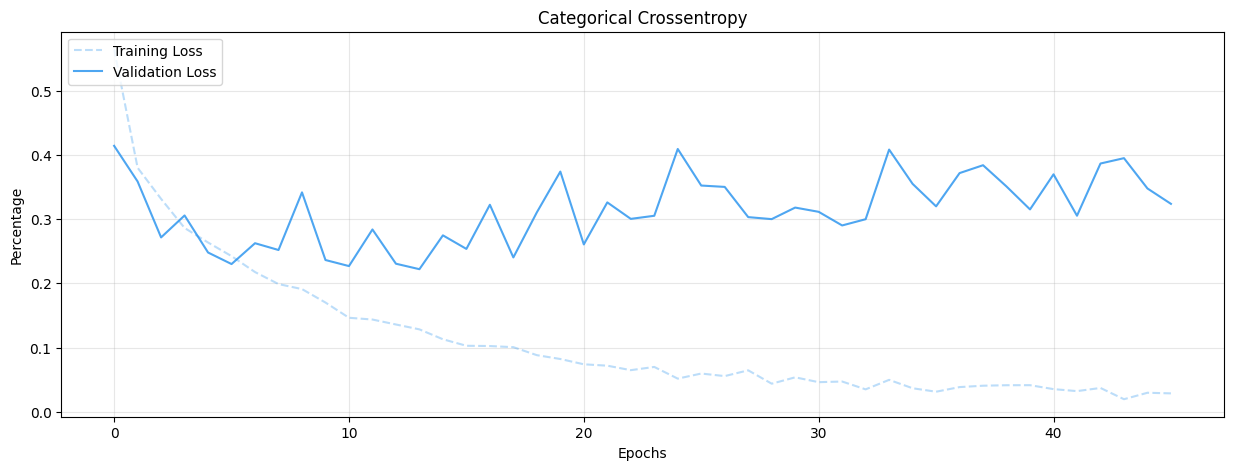

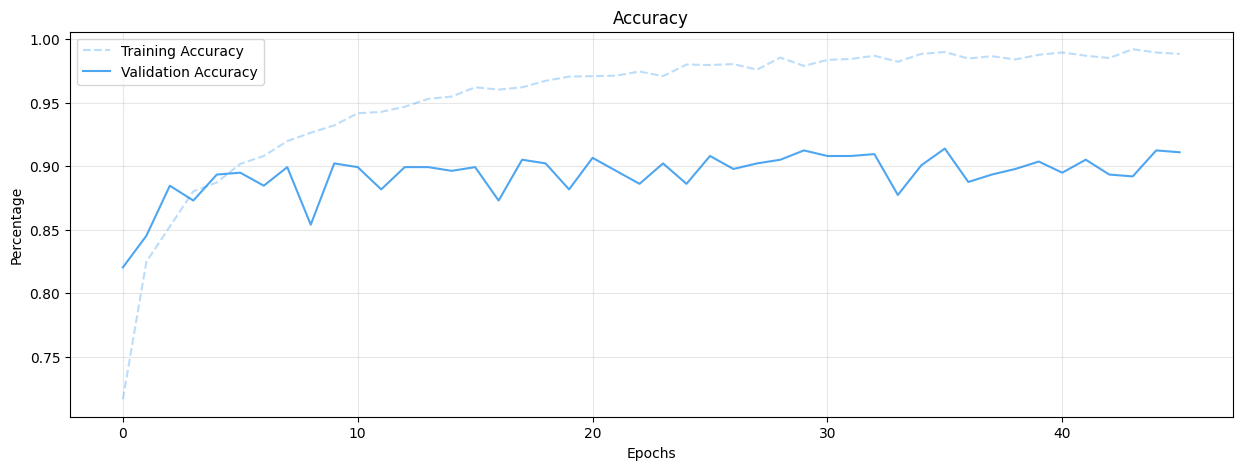

In [29]:
# Loss
plt.figure(figsize=(15, 5))
plt.plot(history['loss'], label = 'Training Loss', alpha=.3, color='#2290ee', linestyle='--')
plt.plot(history['val_loss'], label='Validation Loss', alpha=.8, color='#2290ee')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.xlabel('Epochs')
plt.ylabel('Percentage')

# Accuracy
plt.figure(figsize=(15, 5))
plt.plot(history['accuracy'], label = 'Training Accuracy', alpha=.3, color='#2290ee', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation Accuracy', alpha=.8, color='#2290ee')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.xlabel('Epochs')
plt.ylabel('Percentage')

plt.show()

Accuracy: 0.916
Precision: 0.9165
Recall: 0.916
F1: 0.916


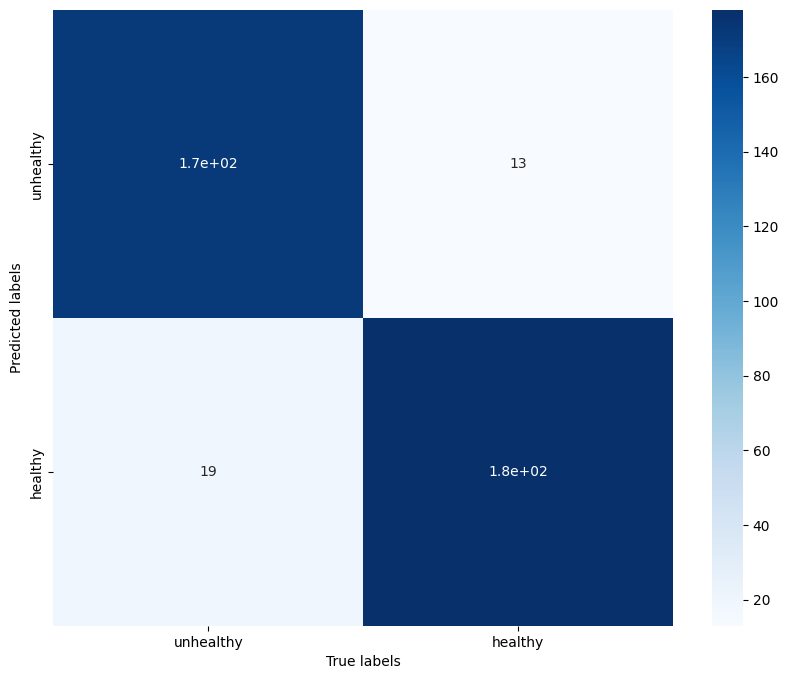

In [27]:
# Predictions
predictions = model.predict(img_test, verbose=0)

# Accuracy, precision, recall and F1 metrics
cm = confusion_matrix(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1))
accuracy = accuracy_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(label_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('unhealthy','healthy')), yticklabels=list(('unhealthy','healthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()